In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats
import statsmodels.api as sm
import statsmodels.tsa.arima_process as sta
import statsmodels.graphics.tsaplots as sgt
import scipy.stats as stats
# import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import scipy.stats
%matplotlib inline
# from util_formula import *
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore") 

# 1. Data Exploration

In [2]:
# import data from csv
train = pd.read_csv('P2train.csv', parse_dates=['Time'])
test = pd.read_csv('P2test.csv',parse_dates=['Time'])
P2index = pd.read_csv('P2index.csv')

In [3]:
# remove duplicated rows and fill missing values
df_index = pd.DataFrame(index=pd.date_range('2012-10-02 09:00:00','2017-12-22 16:00:00',freq='H'))
df_train_all = df_index.merge(train.groupby(train.Time).mean(), how='left',left_index=True, right_index=True)
df_train_all =df_train_all.interpolate()
df_train_all= df_train_all.merge(train.drop_duplicates(subset=['Time']).set_index('Time')[['IsHoliday','WeatherMain','WeatherDescription']], how='left',left_index=True,  right_index=True)
# df_train_all

In [4]:
# Add year, month, day to dataframe
def time_breakdown(df):
    # df= df_all.copy()
    # Prepare data
    df['Time'] = df.index
    df['year'] = [d.year for d in df.Time]
    df['month'] = [d.strftime('%b') for d in df.Time]
    df['week'] = [d.strftime('%A') for d in df.Time]
    df['hour'] = [d.strftime('%H') for d in df.Time]
    return df

df_train_all =time_breakdown(df_train_all)
df_train_all['IsHoliday'] = df_train_all['IsHoliday'] != 'None'
df_train_all.head()

,Temp,Rain1h,Snow1h,CloudsAll,TrafficVolume,IsHoliday,WeatherMain,WeatherDescription,Time,year,month,week,hour
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,False,Clouds,scattered clouds,2012-10-02 09:00:00,2012,Oct,Tuesday,09
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,False,Clouds,broken clouds,2012-10-02 10:00:00,2012,Oct,Tuesday,10
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,False,Clouds,overcast clouds,2012-10-02 11:00:00,2012,Oct,Tuesday,11
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,False,Clouds,overcast clouds,2012-10-02 12:00:00,2012,Oct,Tuesday,12
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,False,Clouds,broken clouds,2012-10-02 13:00:00,2012,Oct,Tuesday,13


In [5]:
# preprocess test data to match with training data set
df_test_all=test.set_index('Time')
df_test_all =time_breakdown(df_test_all)
df_test_all['IsHoliday'] = df_test_all['IsHoliday'] != 'None'
# df_test_all= test.groupby(df_test_all.Time).mean()
df_test_all['TrafficVolume'].replace(0, np.nan,inplace=True)
df_test_all

,IsHoliday,Temp,Rain1h,Snow1h,CloudsAll,WeatherMain,WeatherDescription,TrafficVolume,Time,year,month,week,hour
Time,,,,,,,,,,,,,
2017-12-22 17:00:00,False,268.86,0.0,0.0,75,Clouds,broken clouds,4871.0,2017-12-22 17:00:00,2017,Dec,Friday,17
2017-12-22 18:00:00,False,267.68,0.0,0.0,40,Clouds,scattered clouds,4105.0,2017-12-22 18:00:00,2017,Dec,Friday,18
2017-12-22 19:00:00,False,267.36,0.0,0.0,90,Clouds,overcast clouds,3464.0,2017-12-22 19:00:00,2017,Dec,Friday,19
2017-12-22 20:00:00,False,267.43,0.0,0.0,90,Clouds,overcast clouds,2972.0,2017-12-22 20:00:00,2017,Dec,Friday,20
2017-12-22 21:00:00,False,267.29,0.0,0.0,90,Clouds,overcast clouds,3096.0,2017-12-22 21:00:00,2017,Dec,Friday,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,False,283.45,0.0,0.0,75,Clouds,broken clouds,NaN,2018-09-30 19:00:00,2018,Sep,Sunday,19
2018-09-30 20:00:00,False,282.76,0.0,0.0,90,Clouds,overcast clouds,2781.0,2018-09-30 20:00:00,2018,Sep,Sunday,20
2018-09-30 21:00:00,False,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159.0,2018-09-30 21:00:00,2018,Sep,Sunday,21


In [6]:
# index of test data to be predicted
to_predict_index = (P2index['Index'] - 1).tolist()

# timestamp to be predicted
to_predict_time = test.loc[to_predict_index, 'Time'].apply(pd.to_datetime).tolist()
to_predict_index

[210,
 228,
 251,
 272,
 295,
 326,
 364,
 385,
 408,
 415,
 444,
 481,
 502,
 514,
 535,
 577,
 584,
 617,
 654,
 659,
 685,
 723,
 747,
 765,
 793,
 802,
 842,
 856,
 879,
 895,
 921,
 966,
 968,
 1009,
 1018,
 1059,
 1063,
 1109,
 1126,
 1141,
 1174,
 1201,
 1226,
 1251,
 1270,
 1290,
 1326,
 1340,
 1366,
 1387,
 1413,
 1445,
 1462,
 1473,
 1519,
 1523,
 1563,
 1572,
 1609,
 1632,
 1654,
 1667,
 1704,
 1715,
 1750,
 1767,
 1786,
 1822,
 1854,
 1861,
 1890,
 1904,
 1929,
 1966,
 1988,
 2010,
 2046,
 2056,
 2085,
 2115,
 2139,
 2154,
 2177,
 2191,
 2238,
 2256,
 2272,
 2311,
 2322,
 2349,
 2371,
 2391,
 2418,
 2445,
 2466,
 2498,
 2504,
 2530,
 2574,
 2588,
 2610,
 2643,
 2671,
 2688,
 2711,
 2719,
 2760,
 2779,
 2801,
 2823,
 2842,
 2880,
 2904,
 2932,
 2935,
 2963,
 2997,
 3019,
 3052,
 3077,
 3095,
 3110,
 3140,
 3154,
 3199,
 3214,
 3228,
 3271,
 3285,
 3296,
 3333,
 3366,
 3372,
 3398,
 3422,
 3455,
 3480,
 3494,
 3521,
 3540,
 3566,
 3583,
 3611,
 3652,
 3660,
 3700,
 3727,
 375

<Figure size 1368x432 with 0 Axes>

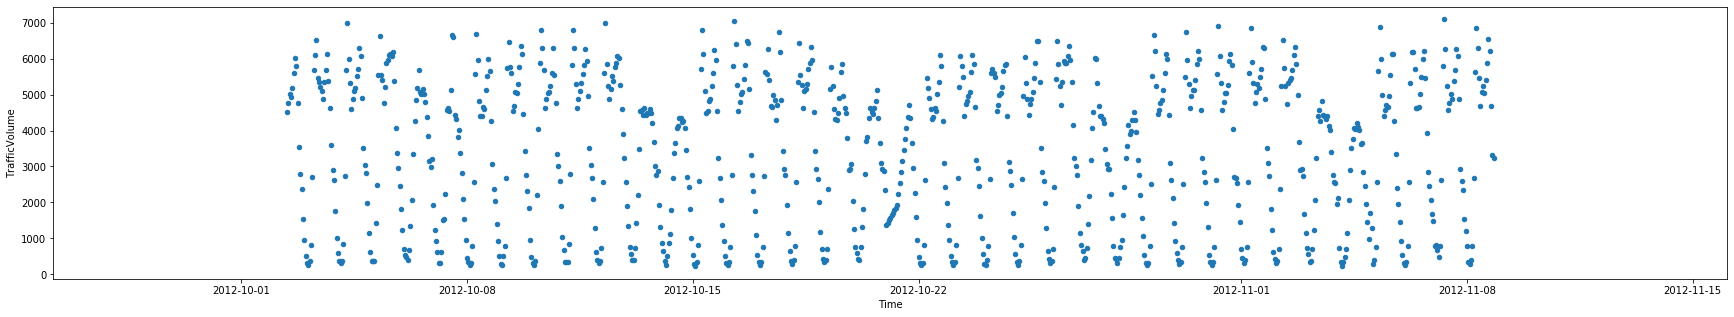

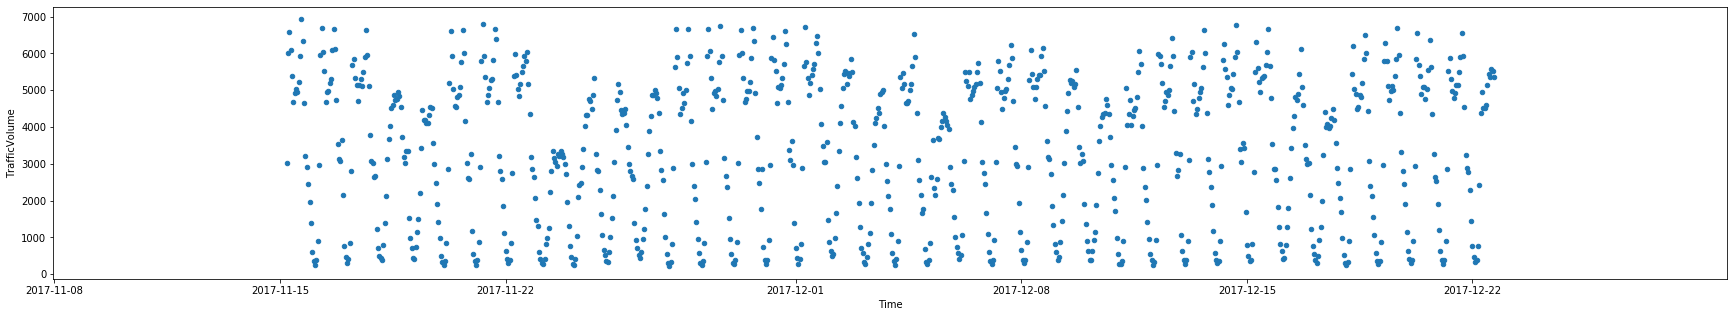

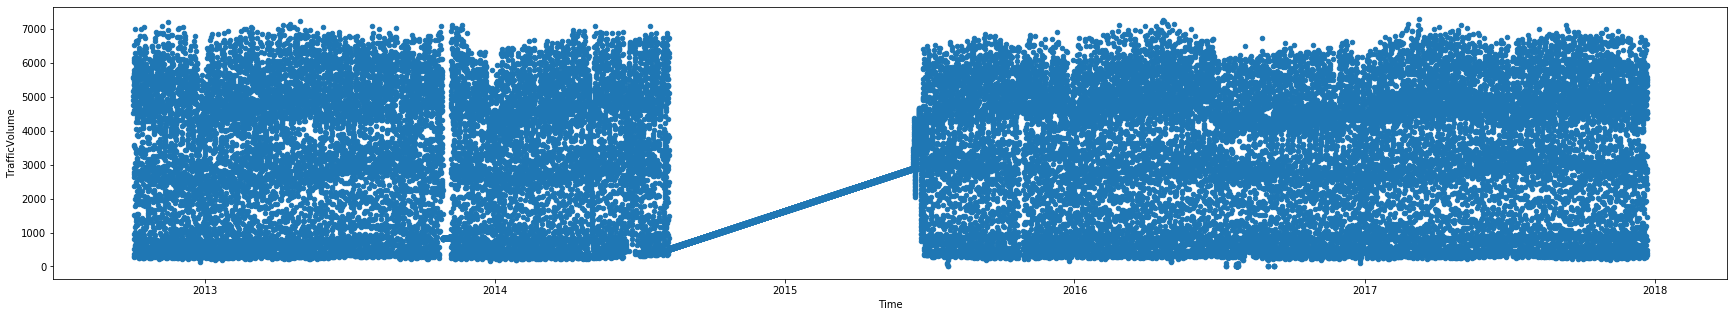

In [8]:
# plot the training data
df_train_all[1:900].plot( 'Time', 'TrafficVolume', kind='scatter', figsize=(30,5))
df_train_all[-900:].plot( 'Time', 'TrafficVolume', kind='scatter', figsize=(30,5))
df_train_all.plot( 'Time', 'TrafficVolume', kind='scatter', figsize=(30,5))

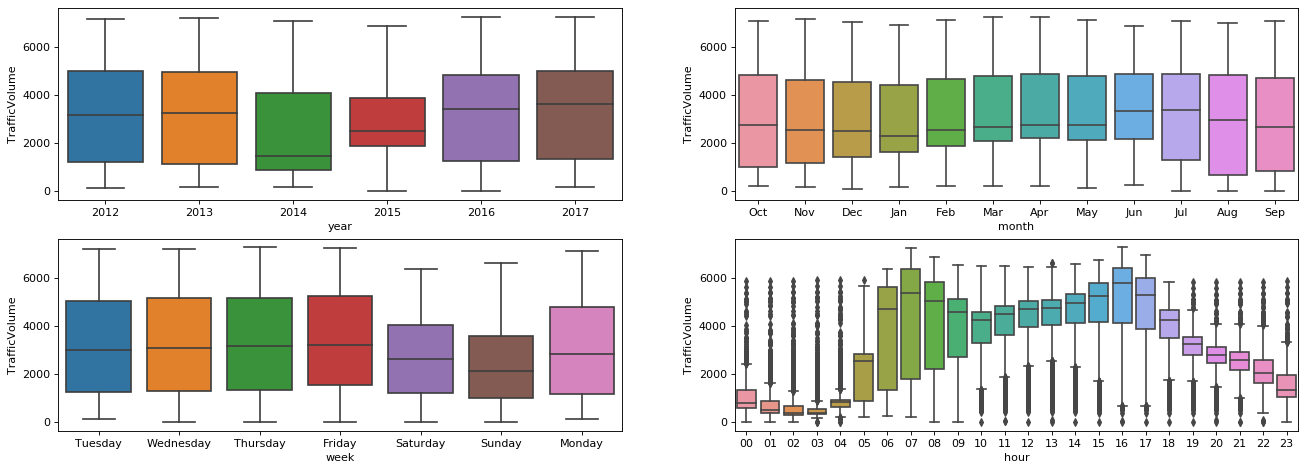

In [10]:
# Draw Plot of year month week hours
fig, axes = plt.subplots(2, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='TrafficVolume', data=df_train_all, ax=axes[0,0])
sns.boxplot(x='month', y='TrafficVolume', data=df_train_all, ax=axes[0,1])
sns.boxplot(x='week', y='TrafficVolume', data=df_train_all, ax=axes[1,0])
sns.boxplot(x='hour', y='TrafficVolume', data=df_train_all, ax=axes[1,1])

# Set Title
# axes[0,0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
# axes[0,1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# 2. Regression on Time 

### 2-1 Linear regression model with seasonal dummy variables

In [7]:
# Train regression model with seasonal dummy variables 
df1 = df_train_all[(df_train_all['Time'] > '2015-11-06')]
df1['T_difference'] = (df1.Time - df1.Time.iloc[0]).astype('timedelta64[h]')
dummyfit = smf.ols('TrafficVolume~T_difference+C(hour)+C(week)+C(month)+C(year)', data = df1).fit()
# dummyfit = smf.ols('TrafficVolume~T_difference+C(hour)+C(week)+C(year)+C(month)', data = df1).fit()
dummyfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     2240.
Date:                Fri, 12 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:02:10   Log-Likelihood:            -1.5097e+05
No. Observations:               18664   AIC:                         3.020e+05
Df Residuals:                   18620   BIC:                         3.024e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1067.9968    142.019      7.520      0.000     789.626    1346.368
C(hour)[T.01]         -336.7580     40.034     -8.412      0.000    -415.228    -258.288
C(hour)[T.02]         -467.2311     40.034    -11.671      0.000    -545.701    -388.761
C(hour)[T.03]         -474.5422     40.034    -11.854      0.000    -553.012    -396.072
C(hour)[T.04]         -113.9238     40.034     -2.846      0.004    -192.394     -35.454
C(hour)[T.05]         1285.5127     40.034     32.111      0.000    1207.043    1363.983
C(hour)[T.06]         3255.4656     40.034     81.318      0.000    3176.995    3333.936
C(hour)[T.07]         3875.5176     40.034     96.806      0.000    3797.047    3953.988
C(hour)[T.08]         3742.0131     40.034     93.470      0.000    3663.542    3820.484
C(hour)[T.09]         3521.1648     40.034     87.954      0.000    3442.694    3599.636
C(hour)[T.10]         3352.3485     40.035     83.736      0.000    3273.877    3430.820
C(hour)[T.11]         3612.6893     40.035     90.239      0.000    3534.218    3691.161
C(hour)[T.12]         3836.0578     40.035     95.818      0.000    3757.586    3914.530
C(hour)[T.13]         3860.5196     40.035     96.428      0.000    3782.047    3938.992
C(hour)[T.14]         4055.9055     40.035    101.308      0.000    3977.432    4134.379
C(hour)[T.15]         4371.8000     40.036    109.198      0.000    4293.326    4450.274
C(hour)[T.16]         4814.5517     40.036    120.256      0.000    4736.078    4893.026
C(hour)[T.17]         4444.4883     40.049    110.976      0.000    4365.988    4522.988
C(hour)[T.18]         3427.2415     40.049     85.575      0.000    3348.741    3505.742
C(hour)[T.19]         2468.5127     40.050     61.636      0.000    2390.012    2547.014
C(hour)[T.20]         1997.3013     40.050     49.870      0.000    1918.799    2075.803
C(hour)[T.21]         1801.1064     40.050     44.971      0.000    1722.604    1879.609
C(hour)[T.22]         1353.2539     40.051     33.788      0.000    1274.751    1431.757
C(hour)[T.23]          612.7836     40.051     15.300      0.000     534.279     691.288
C(week)[T.Monday]     -319.2213     21.613    -14.770      0.000    -361.585    -276.857
C(week)[T.Saturday]   -782.8687     21.601    -36.243      0.000    -825.208    -740.529
C(week)[T.Sunday]    -1180.6750     21.609    -54.639      0.000   -1223.030   -1138.320
C(week)[T.Thursday]     -6.3650     21.603     -0.295      0.768     -48.710      35.980
C(week)[T.Tuesday]    -113.0150     21.610     -5.230      0.000    -155.372     -70.658
C(week)[T.Wednesday]   -67.6167     21.607     -3.129      0.002    -109.969     -25.264
C(month)[T.Aug]         63.2549     86.349      0.733      0.464    -105.996     232.506
C(month)[T.Dec]        129.6827    163.456      0.793    

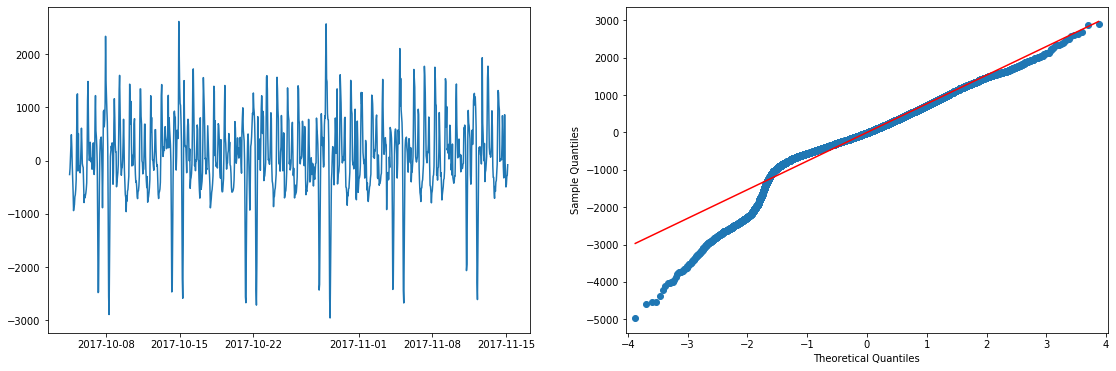

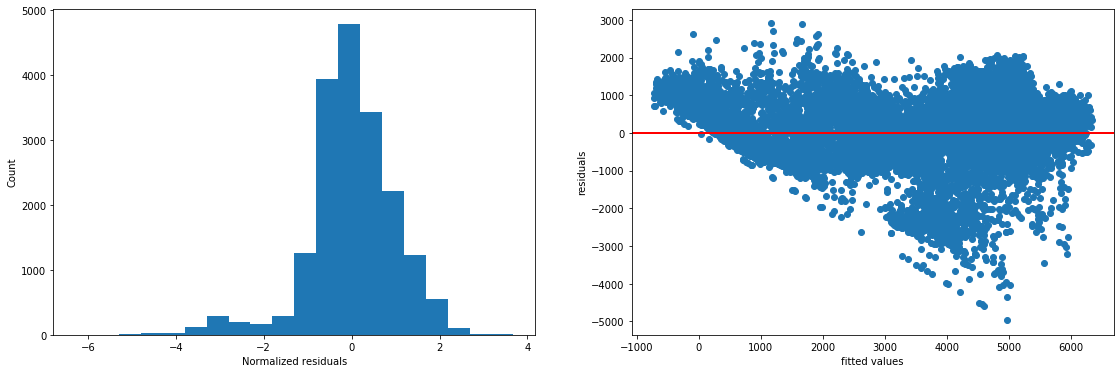

In [9]:
#  Diagnostic plots for regression model with seasonal dummy variables 
res1 = dummyfit.resid
# res = res[-900:,]
fitvalue = dummyfit.fittedvalues
def diagnostic_plots(res,fitvalue ,lags=50,alpha=0.05):
    fig, ax = plt.subplots(1,2,figsize=(19,6))
    ax[0].plot(res[-1900:-900,])
    fig = sm.qqplot(res, stats.distributions.norm, line='r', ax=ax[1])

    fig, ax = plt.subplots(1,2,figsize=(19,6))
    # ax[0].figure(figsize=(8,6))
    ax[0].hist(res,bins=20)
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel('Normalized residuals') 


    # ax[1]=fig.add_subplot(111)
    ax[1].scatter(fitvalue,res)
    ax[1].axhline(y=0, linewidth=2, color = 'r')
    ax[1].set(xlabel='fitted values',ylabel='residuals')
    
diagnostic_plots(res1,fitvalue)

### 2-2 Modeling using Trigonometric Functions
Trigonometric functions: A collection of periodic functions with a variety of frequencies

In [10]:
# transform original data by trigonometric functions 
def trigonometric_transform(data, colName, period, order):
    val = data[colName].values.astype(int);
    pi = 3.141592653589793;
    
    # loop for each order
    for i in range(1, order+1):
        n1 = 'Sin{}'.format(i);
        n2 = 'Cos{}'.format(i);
        data[n1] = np.sin(i*2*pi*val/period);
        data[n2] = np.cos(i*2*pi*val/period);

    return data;
# create the transformation
df2 = df1.copy()
order = 4
trigonometric_transform(df2, 'hour', 24, order);
df2.head()

,Temp,Rain1h,Snow1h,CloudsAll,TrafficVolume,IsHoliday,WeatherMain,WeatherDescription,Time,year,...,hour,T_difference,Sin1,Cos1,Sin2,Cos2,Sin3,Cos3,Sin4,Cos4
2015-11-06 01:00:00,278.48,0.0,0.0,90.0,381.0,False,Clouds,overcast clouds,2015-11-06 01:00:00,2015,...,01,0.0,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5
2015-11-06 02:00:00,278.45,0.0,0.0,90.0,387.0,True,NaN,NaN,2015-11-06 02:00:00,2015,...,02,1.0,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5
2015-11-06 03:00:00,278.42,0.0,0.0,90.0,393.0,False,Clouds,overcast clouds,2015-11-06 03:00:00,2015,...,03,2.0,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0
2015-11-06 04:00:00,278.43,0.0,0.0,90.0,1550.5,True,NaN,NaN,2015-11-06 04:00:00,2015,...,04,3.0,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,-8.660254e-01,-0.5
2015-11-06 05:00:00,278.44,0.0,0.0,90.0,2708.0,False,Clouds,overcast clouds,2015-11-06 05:00:00,2015,...,05,4.0,0.965926,0.258819,0.500000,-8.660254e-01,-7.071068e-01,-7.071068e-01,-8.660254e-01,0.5


In [84]:
colList = list(df2.columns.values)[-8:];
fm = 'TrafficVolume' + '~' + '+ C(week)+ C(month)+' + '+'.join(colList)
# print(fm)
tfit = smf.ols(formula=fm, data=df2).fit()
# print(tfit.summary())
tfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     3464.
Date:                Sat, 13 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:56:04   Log-Likelihood:            -1.5181e+05
No. Observations:               18664   AIC:                         3.037e+05
Df Residuals:                   18638   BIC:                         3.039e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3868.1171     26.218    147.537      0.000    3816.728    3919.507
C(week)[T.Monday]     -319.4051     22.588    -14.141      0.000    -363.679    -275.131
C(week)[T.Saturday]   -783.6789     22.577    -34.711      0.000    -827.932    -739.426
C(week)[T.Sunday]    -1180.5374     22.584    -52.273      0.000   -1224.805   -1136.270
C(week)[T.Thursday]     -6.5178     22.578     -0.289      0.773     -50.772      37.736
C(week)[T.Tuesday]    -113.0137     22.585     -5.004      0.000    -157.283     -68.745
C(week)[T.Wednesday]   -67.4729     22.583     -2.988      0.003    -111.739     -23.207
C(month)[T.Aug]       -166.0962     30.515     -5.443      0.000    -225.909    -106.284
C(month)[T.Dec]       -329.6735     28.494    -11.570      0.000    -385.524    -273.823
C(month)[T.Feb]       -154.3654     31.155     -4.955      0.000    -215.433     -93.298
C(month)[T.Jan]       -354.0642     30.502    -11.608      0.000    -413.850    -294.278
C(month)[T.Jul]       -413.8387     30.499    -13.569      0.000    -473.620    -354.057
C(month)[T.Jun]        -65.6981     30.758     -2.136      0.033    -125.987      -5.409
C(month)[T.Mar]        -45.5452     30.513     -1.493      0.136    -105.353      14.263
C(month)[T.May]       -124.5045     30.513     -4.080      0.000    -184.313     -64.696
C(month)[T.Nov]       -339.4224     28.405    -11.949      0.000    -395.099    -283.745
C(month)[T.Oct]       -164.6111     30.506     -5.396      0.000    -224.406    -104.816
C(month)[T.Sep]       -194.1318     30.751     -6.313      0.000    -254.407    -133.856
Sin1                  -699.6888      8.541    -81.925      0.000    -716.429    -682.948
Cos1                 -2133.0766      8.540   -249.769      0.000   -2149.816   -2116.337
Sin2                  -328.8223      8.540    -38.503      0.000    -345.562    -312.083
Cos2                  -638.6341      8.541    -74.775      0.000    -655.375    -621.893
Sin3                  -347.3261      8.540    -40.669      0.000    -364.066    -330.586
Cos3                   468.4200      8.540     54.848      0.000     451.680     485.160
Sin4                   -11.7873      8.540     -1.380      0.168     -28.527       4.952
Cos4                   153.8189      8.541     18.010      0.000     137.079     170.559
==============================================================================
Omnibus:                     1244.033   Durbin-Watson:                   0.466
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2910.365
Skew:                          -0.419   Prob(JB):                         0.00
Kurtosis:                       4.744   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors 

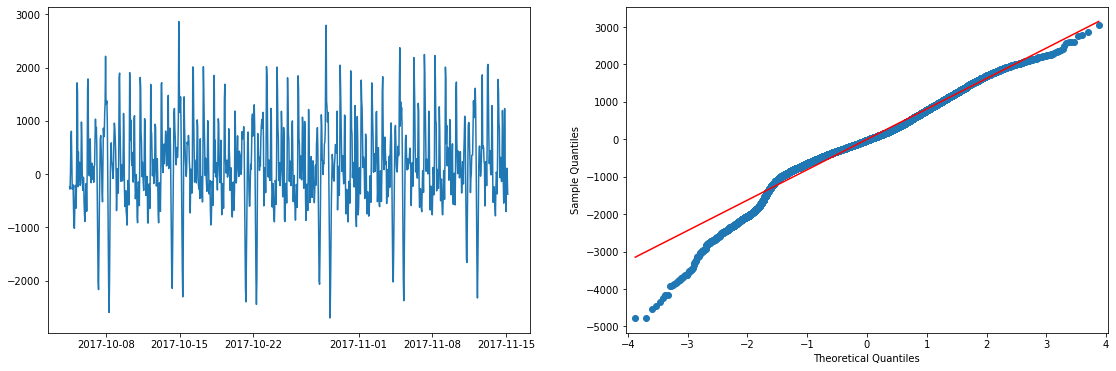

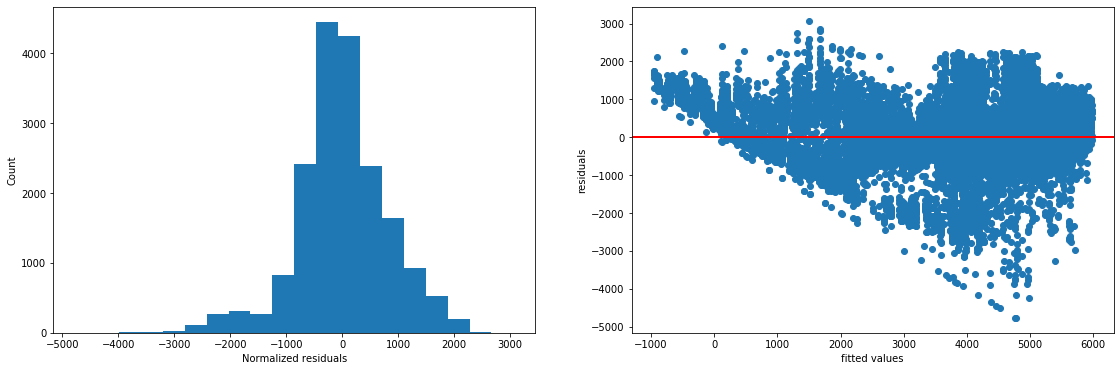

In [85]:
#  Diagnostic plots for regression model by using Trigonometric Functions
res2 = tfit.resid
diagnostic_plots(res2, tfit.fittedvalues)

# 2.2 Exponential smoothing

### 2.2.1 Simple Exponential smoothing

Yt = β0 + ϵt

Ln = αYn + (1 − α)Ln−1 = Σ α(1 − α)n−i*Yi


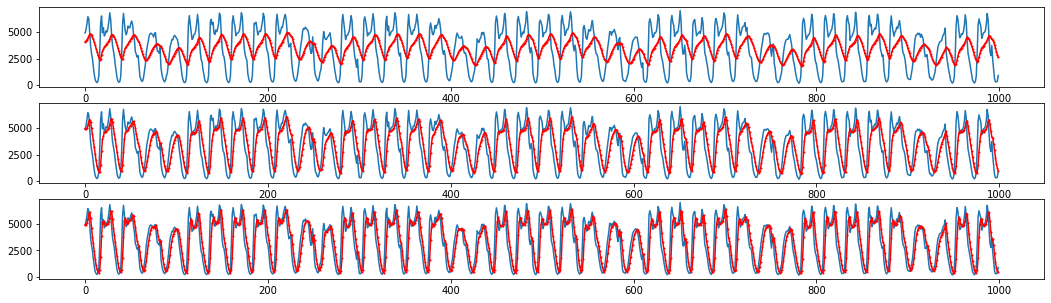

In [74]:
# set alpha to 0.1, 0.3, 0.5 seperately for Simple Exponential Smoothing
df=df1.TrafficVolume[-1900:-900]
df

fig, ax = plt.subplots(3,1,figsize=(18,5))
al = 0.1;
fit1 = SimpleExpSmoothing(df).fit(smoothing_level=al, optimized=True)
ax[0].plot(range(0,df.shape[0]), df)
ax[0].plot(range(0,df.shape[0]), fit1.fittedvalues, marker='o', color='red',markersize=1)

al = 0.3;
fit1 = SimpleExpSmoothing(df).fit(smoothing_level=al, optimized=False)
ax[1].plot(range(0,df.shape[0]), df)
ax[1].plot(range(0,df.shape[0]), fit1.fittedvalues, marker='o', color='red',markersize=1)

al = 0.5;
fit1 = SimpleExpSmoothing(df).fit(smoothing_level=al, optimized=False)
ax[2].plot(range(0,df.shape[0]), df)
ax[2].plot(range(0,df.shape[0]), fit1.fittedvalues, marker='o', color='red',markersize=1)

Text(0.5, 1.0, '$\\alpha=0.995$')

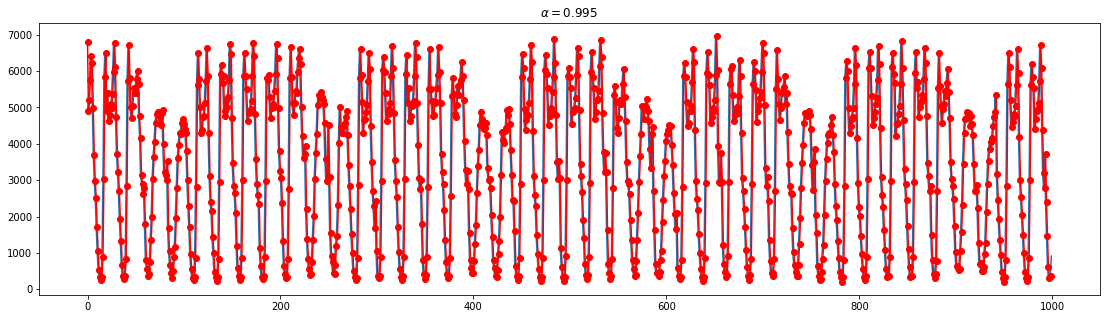

In [88]:
# use software to find the optimal alpha = 0.995
fit1 = SimpleExpSmoothing(df, initialization_method="heuristic").fit()
fig, ax = plt.subplots(figsize=(19,5))
plt.plot(range(0,df.shape[0]), df)
plt.plot(range(0,df.shape[0]), fit1.fittedvalues, marker='o', color='red')
plt.title(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])

In [89]:
fit1.summary()

Dep. Variable:,TrafficVolume,No. Observations:,1000
Model:,SimpleExpSmoothing,SSE,760388237.529
Optimized:,True,AIC,13545.584
Trend:,None,BIC,13555.400
Seasonal:,None,AICC,13545.625
Seasonal Periods:,None,Date:,"Tue, 09 Nov 2021"
Box-Cox:,False,Time:,11:24:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,6798.8000,l.0,True


### 2.2.2 Double Exponential smoothing

Yt = β0 + β1t + ϵt
Level smoothing: Ln = αYn + (1 − α)(Ln−1 + Bn−1)
Bn−1 is the estimate of β1 at step n − 1
Growth rate smoothing: Bn = γ(Ln − Ln−1) + (1 − γ)Bn−1

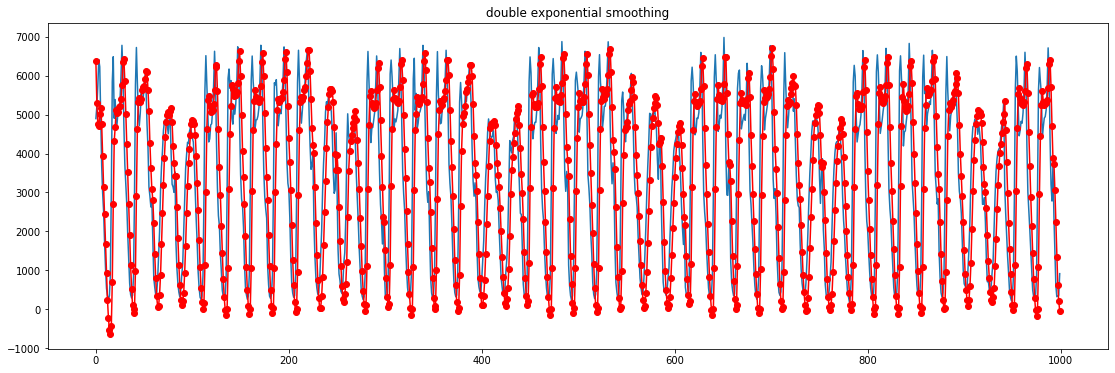

In [77]:
# set alpha and beta to 0.4 and 0.1 seperately for Double Exponential Smoothing
fit2 = Holt(df, initialization_method="estimated").fit(smoothing_level=0.4, smoothing_trend=0.1, optimized=False)

fig = plt.figure(figsize=(19,6))
plt.plot(range(0,df.shape[0]), df)
plt.plot(range(0,df.shape[0]), fit2.fittedvalues, marker="o", color='red')
plt.title("double exponential smoothing");

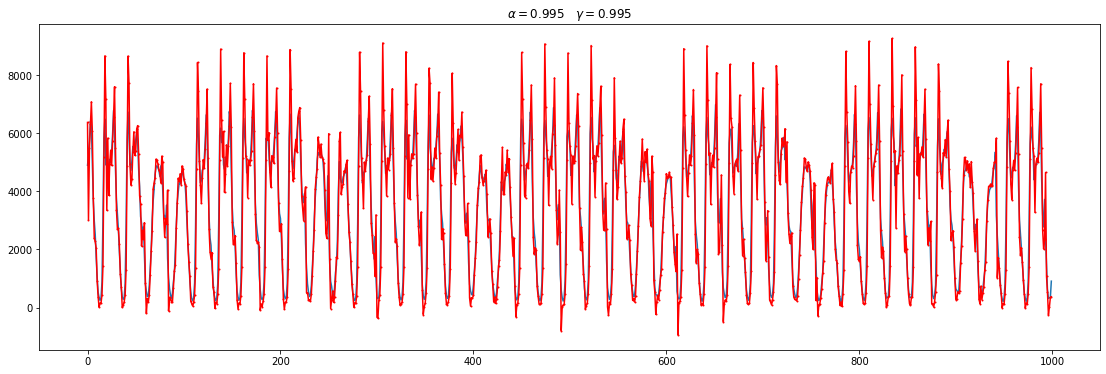

In [79]:
# use software to find the optimal alpha and beta values
optfit = Holt(df, initialization_method="estimated").fit()
# fcast1 = fit1.forecast(5).rename("Holt's linear trend")
fig = plt.figure(figsize=(19,6))
plt.plot(range(0,df.shape[0]), df)
plt.plot(range(0,df.shape[0]), optfit.fittedvalues, marker="o", color='red', markersize=1)
plt.title(r'$\alpha=%s$'%optfit.model.params['smoothing_level'] + r'   $\gamma=%s$'%optfit.model.params['smoothing_trend']);

In [80]:
optfit.summary()

Dep. Variable:,TrafficVolume,No. Observations:,1000
Model:,Holt,SSE,637642390.091
Optimized:,True,AIC,13373.533
Trend:,Additive,BIC,13393.164
Seasonal:,None,AICC,13373.617
Seasonal Periods:,None,Date:,"Tue, 09 Nov 2021"
Box-Cox:,False,Time:,10:25:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.9950000,beta,True


## 3. Holt-Winters Method

Observation Y: Yt = β0 + β1t + SNt + ϵt

β0, β1, SNt need to be updated, to return series of smoothed points
Prediction/level L: Ln = α(Yn − SNn−L) + (1 − α)(Ln−1 + Bn−1)
Trend term B(n):  Bn = γ(Ln − Ln−1) + (1 − γ)Bn−1
Seasonal Term: SNn = δ(Yn − Ln) + (1 − δ)SNn−L


Dep. Variable:,TrafficVolume,No. Observations:,1000
Model:,ExponentialSmoothing,SSE,276001574.456
Optimized:,True,AIC,12584.162
Trend:,Additive,BIC,12721.579
Seasonal:,Additive,AICC,12586.081
Seasonal Periods:,24,Date:,"Tue, 09 Nov 2021"
Box-Cox:,False,Time:,10:32:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9596429,alpha,True
smoothing_trend,0.0001,beta,True


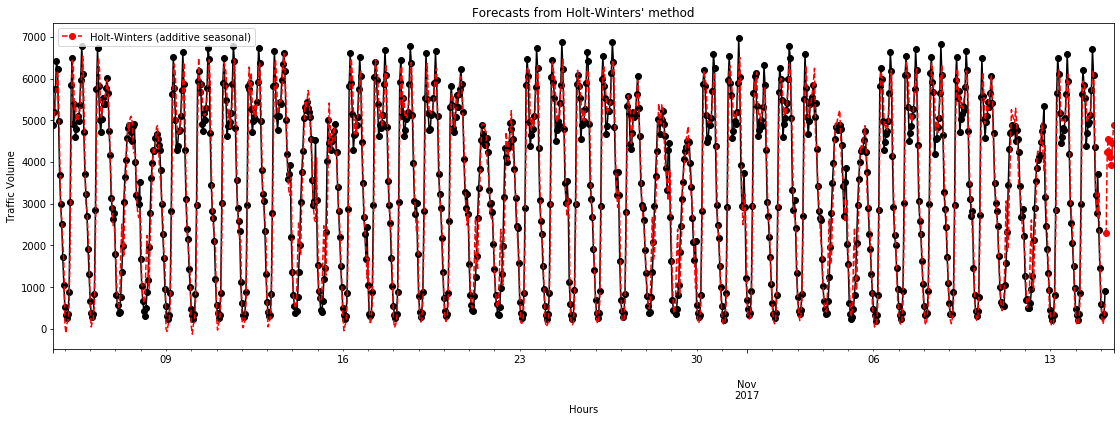

In [84]:
# set seasonal_periods to 24hrs for Triple  Exponential Smoothing
fit3 = ExponentialSmoothing(df, seasonal_periods=24, trend='add', seasonal='add', use_boxcox=False, initialization_method="estimated").fit()

ax = df.plot(figsize=(19,6), marker='o', color='black', title="Forecasts from Holt-Winters' method" );
ax.set_ylabel("Traffic Volume")
ax.set_xlabel("Hours")
fit3.fittedvalues.plot(ax=ax, style='--', color='red')
fit3.forecast(8).rename('Holt-Winters (additive seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit3.summary()

Dep. Variable:,TrafficVolume,No. Observations:,1000
Model:,ExponentialSmoothing,SSE,46020454.315
Optimized:,True,AIC,11080.841
Trend:,Additive,BIC,11924.975
Seasonal:,Additive,AICC,11154.659
Seasonal Periods:,168,Date:,"Tue, 09 Nov 2021"
Box-Cox:,False,Time:,19:10:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3975957,alpha,True
smoothing_trend,0.0025796,beta,True


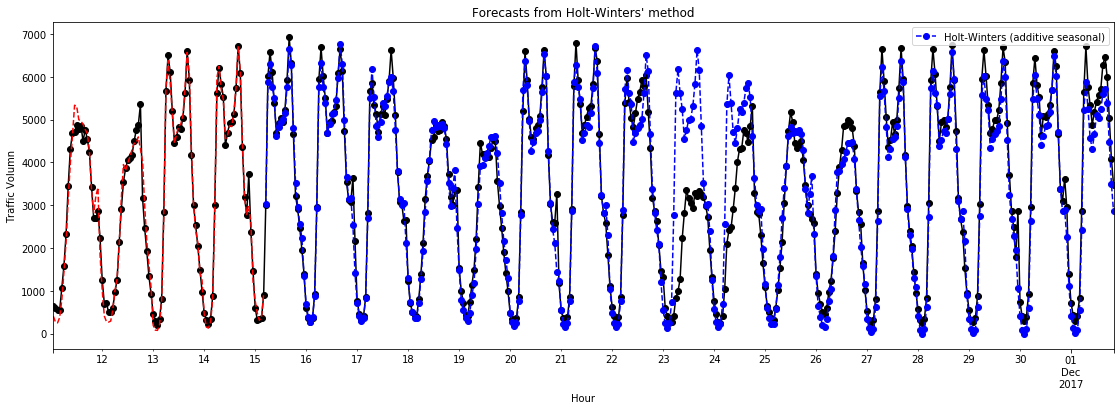

In [113]:
# set seasonal_periods to 24*7 hrs for Triple  Exponential Smoothing 
fit3 = ExponentialSmoothing(df, seasonal_periods=24*7, trend='add', seasonal='add', use_boxcox=False, initialization_method="estimated").fit()
fit3.summary()

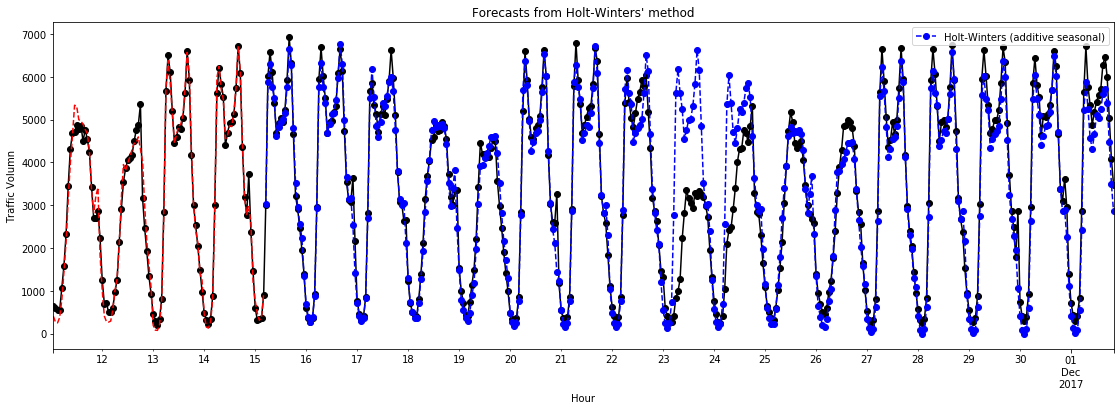

In [15]:
# plot the fitted value vs. true values
ax = df1.TrafficVolume[-1000:-500].plot(figsize=(19,6), marker='o', color='black', title="Forecasts from Holt-Winters' method" )
ax.set_ylabel("Traffic Volumn")
ax.set_xlabel("Hour")
fit3.fittedvalues[-100:].plot(ax=ax, style='--', color='red')
fit3.forecast(400).rename('Holt-Winters (additive seasonal)').plot(ax=ax, style='--', marker='o', color='blue', legend=True)

# 2.3 Free form forecasting

## 2.3.1 Multivariable Regression Model

In [32]:
# Use backward selction to filter unnecessary features 
feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll',  'WeatherMain', 'WeatherDescription','C(hour)','C(week)','C(month)','year']
model_bw=backward('TrafficVolume', feature_set,df_train, criterion="AIC")
model_bw.summary()
##returns ['Snow1h', 'Rain1h']

['IsHoliday']
['IsHoliday', 'Snow1h']
['IsHoliday', 'Rain1h', 'Snow1h']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     2273.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:15:45   Log-Likelihood:            -2.7405e+05
No. Observations:               33820   AIC:                         5.482e+05
Df Residuals:                   33742   BIC:                         5.489e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -9918.7756   5007.741     -1.981      0.048   -1.97e+04    -103.431
WeatherMain[T.Clouds]                                      -892.6823    441.194     -2.023      0.043   -1757.438     -27.927
WeatherMain[T.Drizzle]                                     -673.7843    418.562     -1.610      0.107   -1494.180     146.612
WeatherMain[T.Fog]                                         -495.8359    278.072     -1.783      0.075   -1040.867      49.195
WeatherMain[T.Haze]                                        -586.9424    276.480     -2.123      0.034   -1128.853     -45.031
WeatherMain[T.Mist]                                        -539.2776    276.295     -1.952      0.051   -1080.826       2.271
WeatherMain[T.Rain]                                       -1193.5492    494.003     -2.416      0.016   -2161.812    -225.286
WeatherMain[T.Smoke]                                       -743.9061    296.367     -2.510      0.012   -1324.795    -163.017
WeatherMain[T.Snow]                                       -1231.4661    486.228     -2.533      0.011   -2184.489    -278.443
WeatherMain[T.Squall]                                      -250.5140    902.495     -0.278      0.781   -2019.435    1518.407
WeatherMain[T.Thunderstorm]                               -1025.3731    504.100     -2.034      0.042   -2013.427     -37.319
WeatherDescription[T.Sky is Clear]                        -1145.7527    551.089     -2.079      0.038   -2225.906     -65.599
WeatherDescription[T.broken clouds]                        -218.8860    110.727     -1.977      0.048    -435.914      -1.858
WeatherDescription[T.drizzle]                              -349.2303    158.008     -2.210      0.027    -658.932     -39.529
WeatherDescription[T.few clouds]                           -260.7823    111.239     -2.344      0.019    -478.814     -42.750
WeatherDescription[T.fog]                                  -495.8359    278.072     -1.783      0.075   -1040.867      49.195
WeatherDescription[T.freezing rain]                        -651.8445    704.636     -0.925      0.355   -2032.956     729.267
WeatherDescription[T.haze]                                 -586.9424    276.480     -2.123      0.034   -1128.853     -45.031
WeatherDescription[T.heavy intensity drizzle]                17.8689    204.548      0.087      0.930    -383.053     418.791
WeatherDescription[T.heavy intensity rain]                 -109.7780    134.614     -0.816      0.415    -373.626     154.070
WeatherDescription[T.heavy snow]                             34.2571    138.468      0.247      0.805    -237.145     305.659
WeatherDescription[T.light intensity drizzle]              

In [30]:
# train the multivariable regression model  
def modelFitting(y, feature_set, data):
    # Fit model on feature_set and calculate RSS
    formula = y + '~' + '+'.join(feature_set)
    # fit the regression model
    print(formula)
    model = smf.ols(formula=formula, data=data).fit()
    return model;

feature_set=['C(hour)', 'C(week)', 'C(month)', 'WeatherMain', 'Temp', 'CloudsAll', 'year','IsHoliday']

model1 = modelFitting('TrafficVolume', feature_set, df_train_all[-24*365*2:])
model1.summary()

TrafficVolume~C(hour)+C(week)+C(month)+WeatherMain+Temp+CloudsAll+year+IsHoliday


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1636.
Date:                Fri, 12 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:31:58   Log-Likelihood:            -1.3318e+05
No. Observations:               16471   AIC:                         2.665e+05
Df Residuals:                   16417   BIC:                         2.669e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -3.45e+05   2.44e+04    -14.137      0.000   -3.93e+05   -2.97e+05
C(hour)[T.01]                -342.6123     42.109     -8.136      0.000    -425.150    -260.075
C(hour)[T.02]                -467.0652     42.370    -11.023      0.000    -550.116    -384.015
C(hour)[T.03]                -499.1934     42.370    -11.782      0.000    -582.242    -416.145
C(hour)[T.04]                -152.1805     42.373     -3.591      0.000    -235.236     -69.125
C(hour)[T.05]                1258.0615     42.391     29.678      0.000    1174.971    1341.152
C(hour)[T.06]                3320.2550     42.312     78.471      0.000    3237.319    3403.191
C(hour)[T.07]                3946.6891     42.479     92.909      0.000    3863.426    4029.953
C(hour)[T.08]                3739.7716     42.501     87.993      0.000    3656.465    3823.078
C(hour)[T.09]                3521.2371     42.670     82.522      0.000    3437.599    3604.875
C(hour)[T.10]                3322.9460     42.360     78.445      0.000    3239.915    3405.977
C(hour)[T.11]                3608.6122     42.587     84.736      0.000    3525.138    3692.087
C(hour)[T.12]                3822.0377     42.516     89.897      0.000    3738.702    3905.373
C(hour)[T.13]                3830.5645     42.953     89.181      0.000    3746.373    3914.756
C(hour)[T.14]                4023.6347     43.115     93.323      0.000    3939.124    4108.146
C(hour)[T.15]                4333.0252     43.224    100.245      0.000    4248.301    4417.749
C(hour)[T.16]                4837.3596     43.073    112.307      0.000    4752.933    4921.786
C(hour)[T.17]                4480.1998     43.380    103.278      0.000    4395.170    4565.230
C(hour)[T.18]                3422.0317     42.848     79.864      0.000    3338.044    3506.019
C(hour)[T.19]                2431.4117     42.970     56.584      0.000    2347.186    2515.638
C(hour)[T.20]                1985.9491     42.749     46.456      0.000    1902.157    2069.742
C(hour)[T.21]                1817.7006     42.458     42.811      0.000    1734.478    1900.924
C(hour)[T.22]                1363.9155     42.349     32.207      0.000    1280.907    1446.924
C(hour)[T.23]                 610.4135     42.116     14.494      0.000     527.862     692.965
C(week)[T.Monday]            -325.1937     22.988    -14.146      0.000    -370.253    -280.135
C(week)[T.Saturday]          -791.7342     22.951    -34.497      0.000    -836.720    -746.748
C(week)[T.Sunday]           -1177.2802     22.977    -51.238      0.000   -1222.317   -1132.243
C(week)[T.Thursday]            15.7395     22.929      0.686      0.492     -29.204      60.682
C(week)[T.Tuesday]           -118.4362     22.966     -5.157      0.000    -163.452     -73.421
C(week)[T.W

In [31]:
# use the trained model to do the test data prediction
y_pred_test = model1.predict(df_test_all)
# y_pred_test.to_csv('linear_pred_test.csv')
test_resid = df_test_all['TrafficVolume'] - y_pred_test
test_resid.index= df_test_all['Time']
test_resid

Time
2017-12-22 17:00:00   -823.738356
2017-12-22 18:00:00   -549.411145
2017-12-22 19:00:00   -169.852680
2017-12-22 20:00:00   -216.545420
2017-12-22 21:00:00     76.013748
                          ...    
2018-09-30 19:00:00           NaN
2018-09-30 20:00:00    502.203594
2018-09-30 21:00:00    172.088172
2018-09-30 22:00:00   -205.275778
2018-09-30 23:00:00     52.159548
Length: 8204, dtype: float64

## 2.3.2 Stationarity Check and Differencing

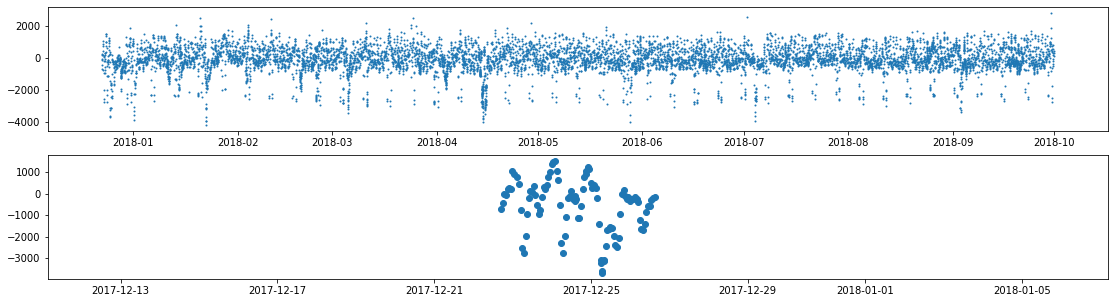

In [31]:
# No differencing
fig, ax = plt.subplots(2,1,figsize=(19,5))
ax[0].scatter(test_resid.index, test_resid,s=1)
ax[1].scatter(df_test_all['Time'][:100], resid[:100],s=1)

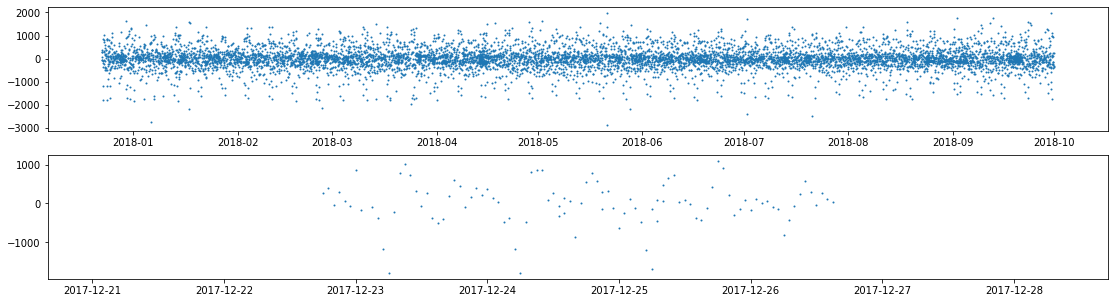

In [33]:
# First order differencing
data = resid - resid.shift(1)
fig, ax = plt.subplots(2,1,figsize=(19,5))
ax[0].scatter(data.index, data,s=1)
ax[1].scatter(df_test_all['Time'][:100], data[:100],s=1)

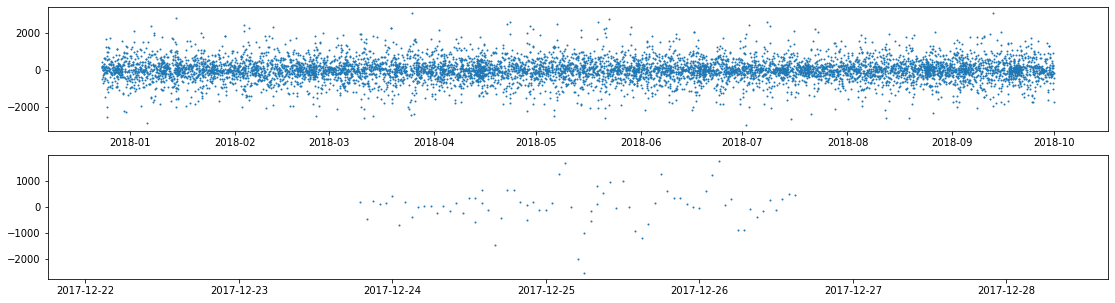

In [34]:
# First order differencing and first order seasonal differencing
data = resid - resid.shift(1) - (resid.shift(24) - resid.shift(25))
fig, ax = plt.subplots(2,1,figsize=(19,5))
ax[0].scatter(data.index, data,s=1)
ax[1].scatter(df_test_all['Time'][:100], data[:100],s=1)

## 2.3.3 ACF and PACF Plots 

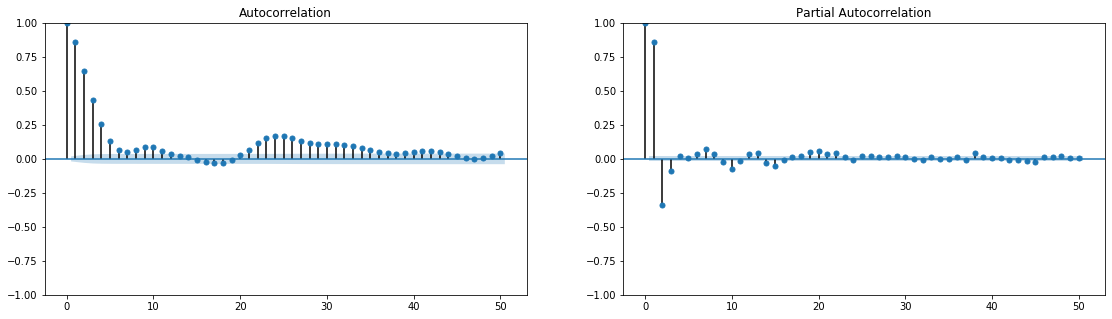

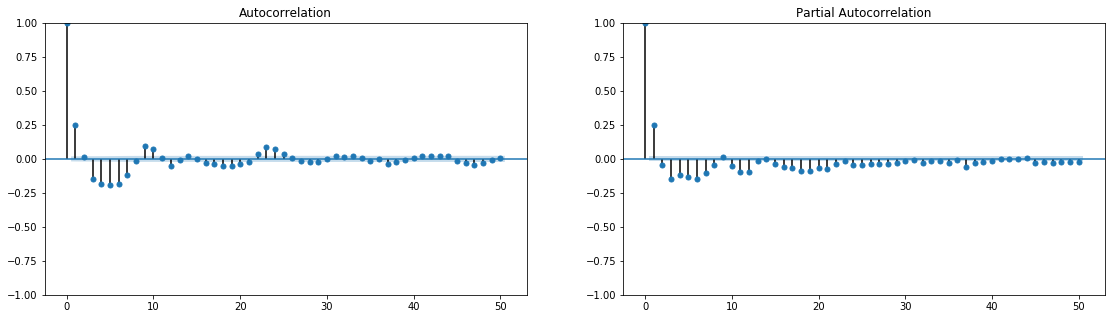

In [56]:
# ACF and PACF for Residuals 
def plot_acf_pacf(data, lags = 80, alpha= 0.1):
    data.dropna(inplace=True)
    fig, ax = plt.subplots(1,2,figsize=(19,5))
    fig = sgt.plot_acf(data, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
    fig = sgt.plot_pacf(data, ax=ax[1], lags=lags, alpha=alpha, method='ols')
    
resid= test_resid
plot_acf_pacf(resid,50)
# ACf die down and PACF cut off suggesst a AR(2) or AR(3) model
# ACF and PACF for Residuals after first order differencing 
plot_acf_pacf(resid - resid.shift(1),50)
# Both ACf and PACF die down suggesst a ARIMA model

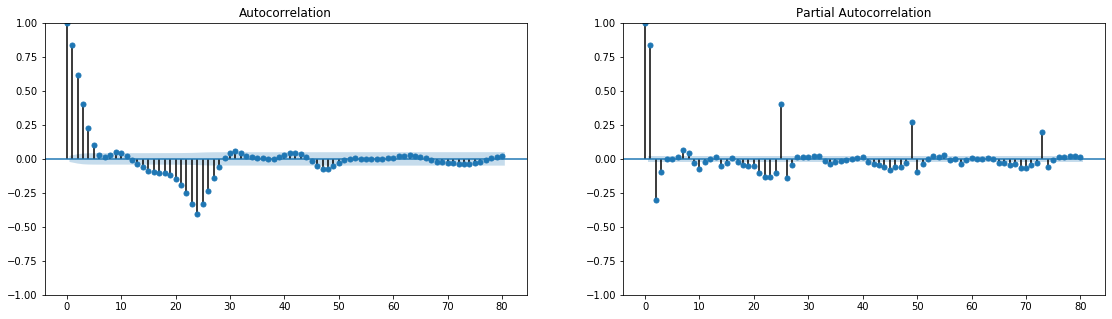

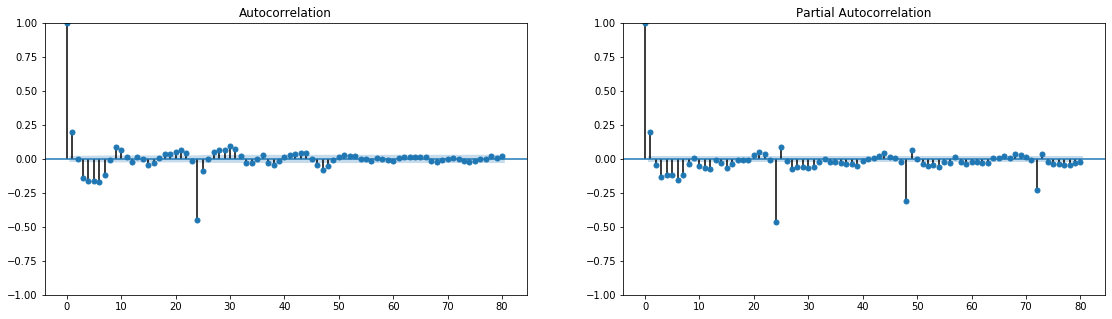

In [20]:
# ACF and PACF for Residuals after first order seasonal differencing 
plot_acf_pacf(resid - resid.shift(24),80)
# ACF and PACF for Residuals after first order seasonal differencing 
plot_acf_pacf(resid - resid.shift(1) - (resid.shift(24) - resid.shift(25)),80)
# ACf die down and PACF cut off suggesst a AR(2) or AR(3) model

## 2.3.4 Grid Search ARIMA Hyperparameters

In [10]:
# Use grid search to find optimal q,d,q for ARIMA model
bic_matrix = []
for p in [1,2,3,4]:
    temp= []
    for q in [0,1,2,3]:
        try:
            model = ARIMA(test_resid, order=(p, 1, q)).fit()
            temp.append(( model.bic,p,q))
            print(( model.bic,p,q))
#             temp.append(( model.bic,p,q))
            del model
        except:
            temp.append('Not Valid')
    bic_matrix.append(temp)
        
bic_matrix 

(117479.3300011658, 1, 0)
(117479.44919382523, 1, 1)
(116695.06976572202, 1, 2)
(116442.88773252648, 1, 3)
(117469.66293809761, 2, 0)
(116427.54852822394, 2, 1)
(116368.42843878928, 2, 2)
(116379.01300748518, 2, 3)
(117305.48553377447, 3, 0)
(116360.70899418752, 3, 1)
(116379.28356731709, 3, 2)
(116363.82492479881, 3, 3)
(117210.7842083087, 4, 0)
(116369.12928012971, 4, 1)
(116378.32013290633, 4, 2)
(116386.77724299642, 4, 3)


[[(117479.3300011658, 1, 0),
  (117479.44919382523, 1, 1),
  (116695.06976572202, 1, 2),
  (116442.88773252648, 1, 3)],
 [(117469.66293809761, 2, 0),
  (116427.54852822394, 2, 1),
  (116368.42843878928, 2, 2),
  (116379.01300748518, 2, 3)],
 [(117305.48553377447, 3, 0),
  (116360.70899418752, 3, 1),
  (116379.28356731709, 3, 2),
  (116363.82492479881, 3, 3)],
 [(117210.7842083087, 4, 0),
  (116369.12928012971, 4, 1),
  (116378.32013290633, 4, 2),
  (116386.77724299642, 4, 3)]]

In [93]:
mod = sm.tsa.SARIMAX(test_resid, order=(3,1,1), seasonal_order=(0, 1, 3, 24))
results = mod.fit()
# results.aic
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                 8204
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2, 3], 24)   Log Likelihood              -58018.015
Date:                                    Thu, 11 Nov 2021   AIC                         116052.030
Time:                                            00:56:22   BIC                         116108.104
Sample:                                                 0   HQIC                        116071.202
                                                   - 8204                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1337      0.007    155.734      0.000       1.119       1.148
ar.L2         -0.2398      0.013    -18.879      0.000      -0.265      -0.215
ar.L3         -0.0899      0.010     -8.864      0.000      -0.110      -0.070
ma.L1         -1.0000      0.212     -4.707      0.000      -1.416      -0.584
ma.S.L24      -0.8935      0.214     -4.177      0.000      -1.313      -0.474
ma.S.L48      -0.1184      0.027     -4.451      0.000      -0.171      -0.066
ma.S.L72       0.0120      0.011      1.056      0.291      -0.010       0.034
sigma2      1.475e+05   1.47e-06   1.01e+11      0.000    1.47e+05    1.47e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4983.84
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+26. Standard errors may be unstable.
"""

## 2.3.5 Iterative forcasting and formating 

In [69]:
# Iterative One-step Out-of-sample Forecasting
for i in to_predict_index[:]:
# for i in [210]:
    given_data = test_resid.iloc[:i,:]
    mod = sm.tsa.SARIMAX(given_data, order=(3,0,1), seasonal_order=(3, 0, 3, 24))
    model_fit= mod.fit()
    forecast = model_fit.forecast().iloc[0]
    test_resid.iloc[i,0]=forecast
    print(i,forecast)
    del model_fit
    del mod
print("Finished")

210 584.3931191968497
228 188.9728857507826
251 863.3639611444885
272 -2068.670050957482
295 -89.60211227863222
326 332.7813826040217
364 507.1535248952198
385 322.9425729913042
408 718.5312335615282
415 494.08361600624505
444 239.37828550213928
481 24.902783444331703
502 189.7217547325902
514 -280.2304261100687
535 582.6607976153063
577 -309.9623351496975
584 301.6045380050722
617 983.2187779338866
654 622.9058405273238
659 -8.060649562459133
685 -460.5143860584739
723 -319.87382142443687
747 -500.7870172539087
765 941.7201686151207
793 -28.714752376492783
802 -864.5283957803811
842 -336.9139719381993
856 1119.7551344484593
879 -3196.9306486919995
895 -256.5892157423327
921 -48.51759814258195
966 476.7319934803147
968 712.9790129718245
1009 422.3673009403629
1018 -884.7857985074565
1059 284.2531403431926
1063 -37.16669558270809
1109 -88.27497854350274
1126 42.83958741910429
1141 -282.3432133702406
1174 -189.41672991489983
1201 194.00246318470357
1226 1571.457333760706
1251 -220.410755

In [72]:
# combine predicted values and residuals and output results to csv
pred=test_resid
forecasted_df = y_pred_test+pred
result_df= forecasted_df.to_frame('A0119545B').iloc[to_predict_index,:]
result_df.to_csv('A0119545B.csv', index = 0, header=1)
result_df

,A0119545B
Time,
2017-12-30 03:00:00,399.439542
2017-12-30 21:00:00,2310.783318
2017-12-31 20:00:00,2779.035024
2018-01-01 17:00:00,3189.359400
2018-01-02 16:00:00,5685.024419
...,...
2018-09-27 02:00:00,430.042449
2018-09-28 05:00:00,2718.155295
2018-09-28 23:00:00,3086.984732


## 2.3.6 Diagnostic Check and Model Interpretation

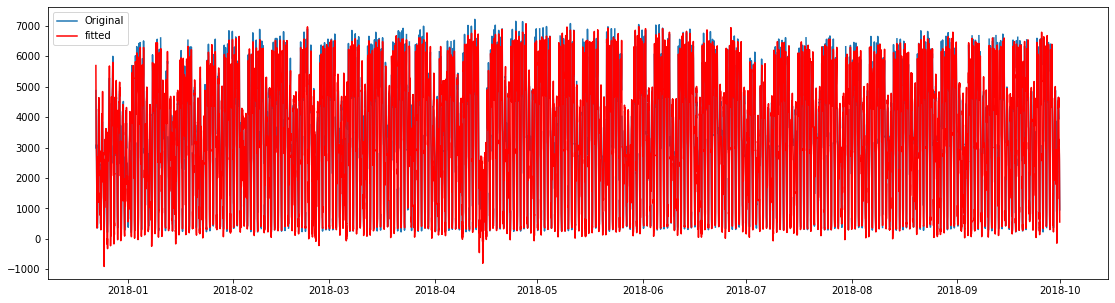

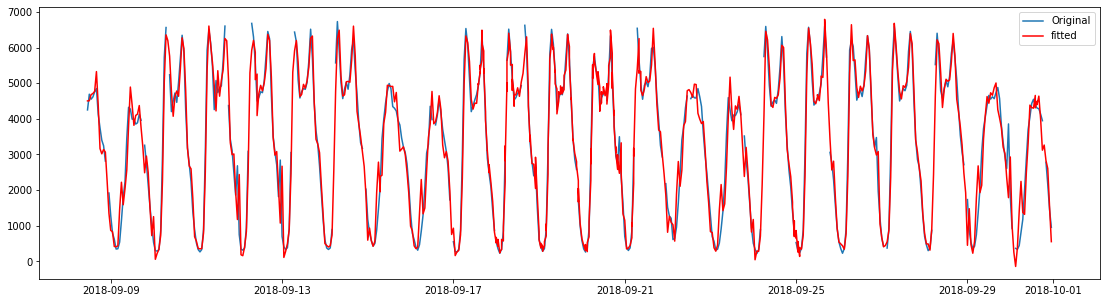

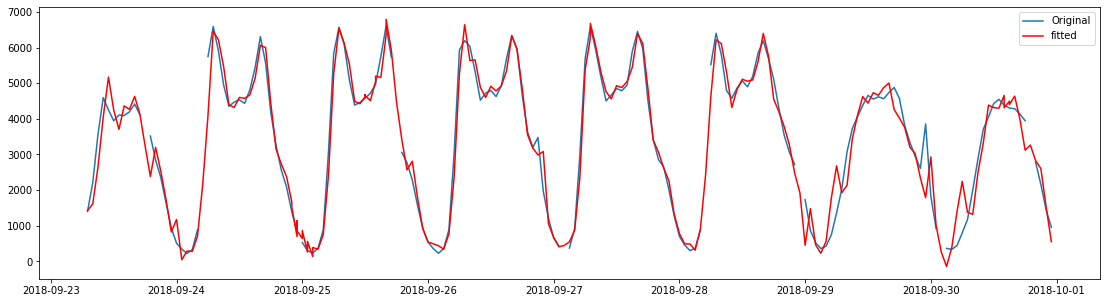

In [101]:
#Plot the final predictions results with the test data
final_result= y_pred_test+pred
fig = plt.figure(figsize=(19,5))
plt.plot(df_test_all['TrafficVolume'], label='Original')
plt.plot(final_result, color='red', label='fitted')
plt.legend(loc='best')
fig = plt.figure(figsize=(19,5))
plt.plot(df_test_all['TrafficVolume'][-24*28:], label='Original')
plt.plot(final_result[-24*28:], color='red', label='fitted')
plt.legend(loc='best')
fig = plt.figure(figsize=(19,5))
plt.plot(df_test_all['TrafficVolume'][-200:], label='Original')
plt.plot(final_result[-200:], color='red', label='fitted')
plt.legend(loc='best')

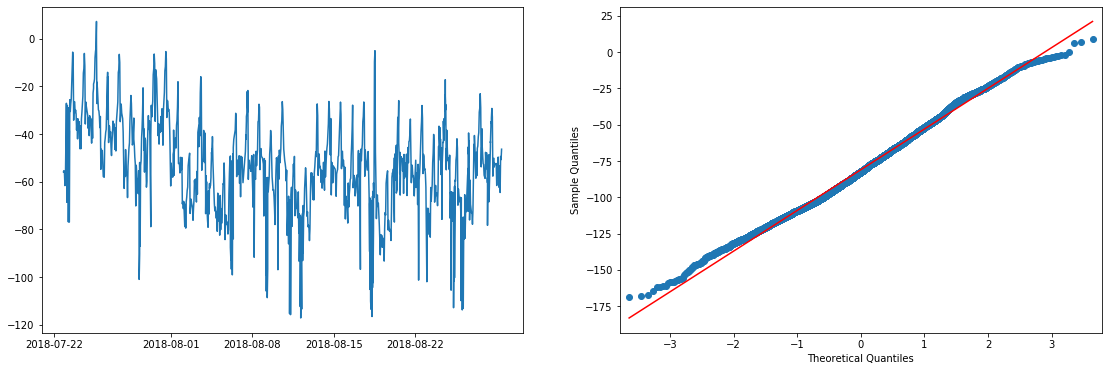

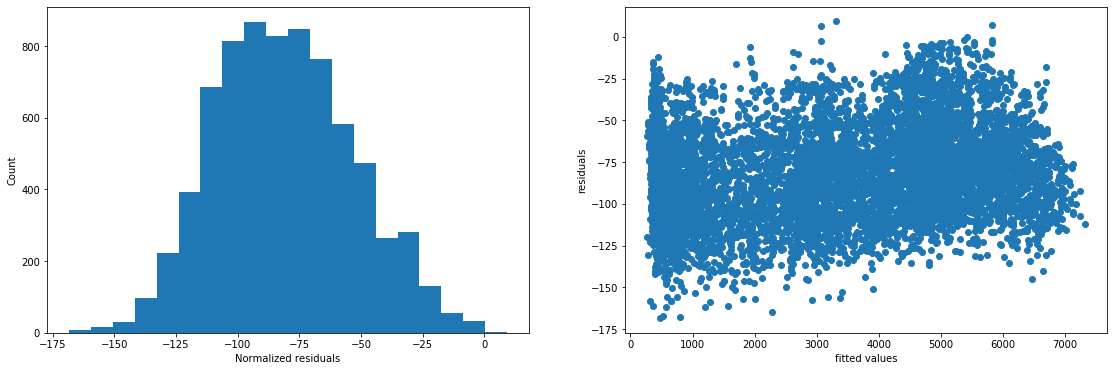

In [87]:
# Diagnostic plots for the test data residuals
test_nonzeros = forecasted_df.drop(forecasted_df.index[to_predict_index])
test_nonzeros = test_nonzeros[test_nonzeros.TrafficVolume!=0]
res5 = test_nonzeros.TrafficVolume - test_nonzeros.A0119545B
diagnostic_plots(res5,test_nonzeros.A0119545B)

In [88]:
# The end ^_^